# ImageNet ILSVRC 2012 Dataset Loader in PyTorch

Load batches of images from ImageNet ILSVRC 2012 Dataset.
This will be used for extended ImageNet experiments where we will apply LRP to multiple images and, consequently, also apply pixel flipping algorithm.

## Reproducibility

Multi-process data loading is by default random. This is because each process will load data from a different part of the dataset.

Further reading:
- https://pytorch.org/docs/stable/notes/randomness.html
- https://pytorch.org/docs/stable/data.html#data-loading-randomness

Setting the seed in any way is not required for reproducibility, the `shuffle` argument in `DataLoader` is enough to ensure that the data is loaded in the same order.

In [1]:
# seed = 0

# import torch
# torch.manual_seed(seed)

# import random
# random.seed(seed)

# import numpy
# numpy.random.seed(seed)

In [2]:
import multiprocessing
from types import SimpleNamespace

import torch
import torchvision

args = SimpleNamespace()
args.nThreads = multiprocessing.cpu_count()

print(f'Using {args.nThreads} threads')

from torchvision import transforms

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

imagenet_data = torchvision.datasets.ImageNet('~/Documents/personal/unterlagen/bildung/uni/master/masterarbeit/code/lrp/data',
                                              split='val', transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=args.nThreads)

Using 4 threads


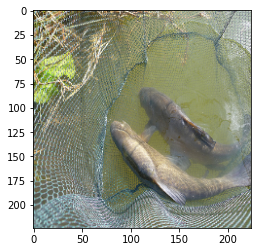

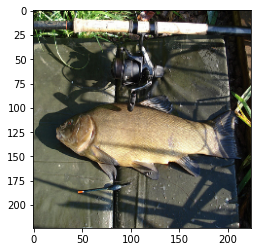

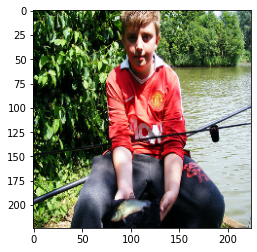

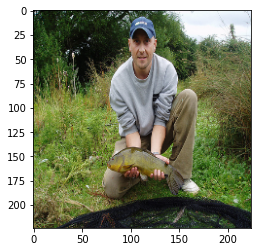

In [3]:
import matplotlib.pyplot as plt

for data in data_loader:
  for i in range(data[0].size(0)):
    plt.imshow(data[0][i].numpy().transpose(1, 2, 0))
    plt.show()

  break

In [4]:
from typing import Callable

import numpy
import torch
import torchvision

from lrp import image, norm

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()

# Input data
# img: numpy.array = image.load_normalized_img('data/castle.jpg')
# X: torch.Tensor = norm_fn(image.img_to_tensor(img))

import numpy
from torchvision import transforms

from lrp import image

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../../data/castle.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Omit printing the model
None

from typing import Tuple

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

from typing import Dict, List, Tuple, Union

import lrp.rules as rules
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

In [5]:
import numpy
from torchvision import transforms

from lrp import image

transform = transforms.Compose([
  # transforms.ToPILImage(mode='RGB'),
  # transforms.Resize((224, 224)), # Requires PIL Image input
  # transforms.CenterCrop(224), # Requires PIL Image input
  # transforms.PILToTensor(), # Converts a PIL Image (H x W x C) to a Tensor of shape (C x H x W).
  transforms.ToTensor(), # Scales value range from [0, 255] to [0, 1]
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  # transforms.RandomErasing(),
])

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../../data/castle.jpg')

# import cv2
# img = cv2.imread('../data/castle.jpg')
# # Convert from BGR to RGB color space
# img = img[..., ::-1]

print('img in RGB', img.shape)
X2 = transform(img)
print(X2.shape)
X2 = torch.unsqueeze(X2, 0)
print(X2.shape)

img in RGB (224, 224, 3)
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
